# Lab4: GPU Programming Lab

### Name: Write your names (Group)


This lab is an introduction of GPU programming with cuda using python. The consists of 3 exercises and a homework. 

- <font color='red'><b> After each exercise, write a detailed summary explaining what you have done, your observations and  conclusions. </b></font>
- <font color='red'><b> Make sure to write your name and your partner name (as registred in Halmstad University) in the name section above. </b></font>
    
- <font color='red'><b> You can do the lab in a group of a maximum of two students. </b></font>

- <font color='red'><b> Only one of the students upload the lab to the blackboard. </b></font>

# CUDA
CUDA is a parallel programming platform and an API that facilitates the access to the CUDA-Enabled GPU functuonality for general purpose computing. It allows speeding up the software by utilizing the GPU power for the parallelizable part of the computation. Many Deep Learning platforms like tenserflow, keras, pytorch and others, rely on CUDA for their computations.

## Common CUDA terminology:
- <b>Host:</b> The CPU
- <b>Device:</b> The GPU
- <b>Host Memory:</b> The system main memory
- <b>Device Memory:</b> The GPU onboard memory
- <b>kernel:</b> A function that runs on the Device

Threads are organized into a grid of blocks, where each block contains a subset of the threads that can cooperate using a block shared memory and can synchronize within each block.

<img src='https://drive.google.com/uc?id=1QzXBVWki0M80KKY_CPzQu1ivE3fAcf2U' width="50%" height="50%"></img>


Parallel portions of an application are executed on the device (GPU) as kernels, where an array of threads excutes each kernel. Each thread has an ID, by which it controls the portion of the data to excute the Kernel. All threads runs the same code on different portions of the data. Grids and Blocls can be organized as 1D, 2D, or 3D arrays. 

<img src='https://drive.google.com/uc?id=1vqh749XFQhfZwq7m7E-VXscBblh58mei' width="50%" height="50%"></img>


# Numba
CUDA is designed to work with C++, but in this Lab we will work with Numba; a Python JIT compiler that translates subsets of the code into machine code, and enables writing a parallel GPU algorithms in Python

# Kernel 
- A Kernel is declared as a function with @cuda.jit decorator.
- A Kernel function cannot have a return value and manages outputs as input-output arrays

## Numba installation


conda install numba

pip install numba

In [ ]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import math
import numba as nb
from numba import cuda
import time

In [2]:
# kernel decleration
@cuda.jit
def my_kernel(io_array):
    io_thread = cuda.grid(1)
    io_array[io_thread] += 12
    pass


To invoc a kernal you have to specify number of blocks in the grid, and the number of threads per block. This can be done by specifying the number of threads per block and calculating how many blocks are required in the grid based on the size of the data.

<font color=red>Important note: In the case that the data size is not divisable by the the number of thread per block, we take the ceiling of the number to reserve an extra block for the remaining part of the data. So the threads in the last block will not be fully occupied.</font>

In [3]:
# kernel invocation
data = np.ones(256)

threadsperblock = 32
blockspergrid = math.ceil(len(data)/threadsperblock)

my_kernel[blockspergrid, threadsperblock](data)


# Exercise 1: Element-wise operation

The following kernel takes 1D array as input and computes the element-wise cube-root x^(1/3) for each element in the array. This an example of an arbitrary costy operation.

- pos: holds the position in the data on which the thread will work.
- Always check if the position exceeds the length of the data for the sake of cases when the data length is not devisable by the number of threads per block.

<img src='https://drive.google.com/uc?id=1AndzjaLH-Lc7N4cg1Ue_zEB3EyJni89N' width="50%" height="50%"></img>

Read the code below and compute the position of the thread on which it will do the computation in the output array.

In [4]:
# kernel decleration
@cuda.jit
def my_kernel(io_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    bx = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    
    # Compute flattened index inside the array
    #pos = cuda.grid(1) # this function returns the same value for the position in a 1D grid
    
    #TODO: compute the correct pos value based on the tread index and the block index and the block width
    pos = tx + (bx * bw)
    
    if pos < io_array.size:
        io_array[pos] = io_array[pos]**(1/3)
        

# kernel invocation
data = np.ones(2048)*27
threadsperblock = 256
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
my_kernel[blockspergrid, threadsperblock](data)
print(data)

[3. 3. 3. ... 3. 3. 3.]


In [9]:
data = np.ones(10000000)
%timeit np.cbrt(data)

1 loop, best of 5: 218 ms per loop


In [10]:
data = np.ones(10000000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)

10 loops, best of 5: 42.9 ms per loop


### Comparison between the previous kernel and Numpy 
- Try different array sizes and compare between CPU (using numpy) and GPU.
- Plot a graph that shows the array sizes on the x axis and the computation time on the y axis of both your kernel and numpy (on the same plot). 
- Is there a relation between the size of the array and difference in performance? Explain what you notice.

### Exercise 1: Results


10000 loops, best of 5: 109 µs per loop
1 loop, best of 5: 1.09 s per loop


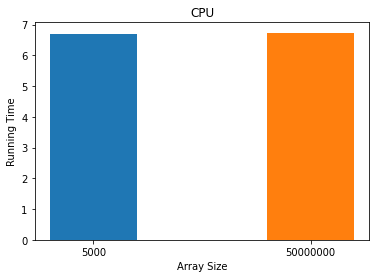

1000 loops, best of 5: 623 µs per loop
1 loop, best of 5: 209 ms per loop


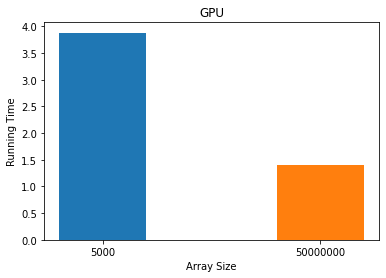

In [11]:
import matplotlib.pyplot as plt


# Small Size 
start = time.time()
data = np.ones(5000)
%timeit np.cbrt(data)
end = time.time()
sm_cpu_time = end - start

start = time.time()
data = np.ones(50000000)
%timeit np.cbrt(data)
end = time.time()
lg_cpu_time = end - start


# Plotting for small size data

plt.bar(['5000'], sm_cpu_time,  width=0.4)
plt.bar(['50000000'], lg_cpu_time,  width=0.4)
plt.xlabel("Array Size")
plt.ylabel("Running Time")
plt.title("CPU")
plt.show()

# Large Size

start = time.time()
data = np.ones(5000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)
end = time.time()
sm_gpu_time = end - start

start = time.time()
data = np.ones(50000000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)
end = time.time()
lg_gpu_time = end - start

# Plotting

plt.bar(['5000'], sm_gpu_time,  width=0.4)
plt.bar(['50000000'], lg_gpu_time,  width=0.4)
plt.xlabel("Array Size")
plt.ylabel("Running Time")
plt.title("GPU")
plt.show()


# There is a relation between size and performance in both CPU and GPU. For smaller size CPU do better than GPU but as we increase the size the performance of GPU become far better as compare to CPU

## Exercise 2: Matrix Multiplication

In matrix multiplication, every kernel will be reponsible of computing one element of the output matrix. It reads one row from the first matrix (A) and one column form the second matrix (B) and computes the dot product of these two vectors and place it in the corresponding cell in the output matrix (C) as shown in the following figure.

<img src='https://drive.google.com/uc?id=16EMuj46QLdwKmIDPU0P6AepZ9SNssb2s' width="50%" height="50%"></img>

Write a kernel to do the multiplication of two matrices.

In [5]:
# CUDA kernel
@cuda.jit
def mat_mul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    # get the 2D position of the thread in which it will compute the dot product of the corresponding vectors 
    row, col = cuda.grid(2)
    
    if row < C.shape[0] and col < C.shape[1]:
        #TODO: Compute the dot product "prod" of the corresponding vectors of this position 
        prod = 0
        for idx in range(A.shape[1]):
          prod += A[row, idx] * B[row, idx]
        C[row, col] = prod


### Create a host function to invoke the kernel

It is a good practice to manually copy the matrices to Device (the GPU memory) using "cuda.to_device" to reduce the unnecessary data transfer between the device and the host.


To test the kernel "mat_mul" we prepare the host function "gpu_dot" which will take two matrices as parameters and returns the the output matrix. The job of this host function is to perpare the data and to invoke the kernel.

Read the code below and calculate how many blocks are required to start the kernel. Use the calculated values to invoke the kernel.

In [6]:
def gpu_dot(A, B):
    #Copy the input matrices to the gpu
    start_copy_time = time.time()
    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B)

    # Allocate memory on the device for the result (Note the shape of the output matrix)
    C_global_mem = cuda.device_array((A.shape[0], B.shape[1]), np.float32)
    
    # Configure the blocks
    # Specify how many threads per block
    threadsperblock = (32, 32)
    
    #TODO: Calculate how many blocks are required
    blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
    blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    dt = time.time()-start_copy_time
    print(f'Copying Input to GPU time: {dt} s')
    start_mult_time = time.time()
    
    #TODO: Start the kernel based on the calculated grid 
    mat_mul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
    
    dt = time.time()-start_mult_time
    print(f'Multiplication Time: {dt} s')
    # Copy the result back to the host
    start_copy_back_time = time.time()
    C = C_global_mem.copy_to_host()
    dt = time.time()-start_copy_back_time
    print(f'Copy result back time: {dt} s')
    dt = time.time()-start_copy_time
    print(f'Total time: {dt} s')
    return C

# Input Test arrays
A = np.full((16384, 2048), 3, np.float32) # matrix containing all 3's
B = np.full((2048, 16384), 4, np.float32) # matrix containing all 4's

#Test the host function
C = gpu_dot(A,B)
print(f'Input Shapes:A:{A.shape}, B:{B.shape}')

print('Output Shape:', C.shape)
print('Output:',C)


Copying Input to GPU time: 0.06344723701477051 s
Multiplication Time: 0.27030396461486816 s


CudaAPIError: ignored

### Testing the calculations time compared to numpy

In [14]:
%timeit np.dot(A,B)

1 loop, best of 5: 14.6 s per loop


### Comparison between the previous gpu_dot and Numpy.dot
- Try different array sizes and compare between CPU (using np.dot) and GPU (using gpu_dot).
- Plot a graph that shows the array sizes (bacause it is a 2D matrix, you can consider the size to be the hight x width) on the x axis and the computation time on the y axis of both your kernel and numpy (on the same plot). 
- Explain what you notice.

### Exercise 2: Results

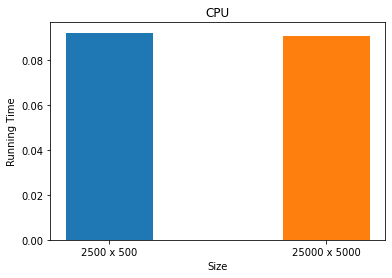

CudaAPIError: ignored

In [15]:
import matplotlib.pyplot as plt


# Small Size 
start = time.time()

A = np.full((2500, 500), 3, np.float32) # matrix containing all 3's
B = np.full((500, 2500), 4, np.float32) # matrix containing all 4's

np.dot(A,B)

end = time.time()
sm_cpu_time = end - start

start = time.time()

A = np.full((2500, 500), 3, np.float32) # matrix containing all 3's
B = np.full((500, 2500), 4, np.float32) # matrix containing all 4's

np.dot(A,B)

end = time.time()
lg_cpu_time = end - start


# Plotting for small size data

plt.bar(['2500 x 500'], sm_cpu_time,  width=0.4)
plt.bar(['25000 x 5000'], lg_cpu_time,  width=0.4)
plt.xlabel("Size")
plt.ylabel("Running Time")
plt.title("CPU")
plt.show()

# GPU 
# Small Size

start = time.time()

A = np.full((2500, 500), 3, np.float32) # matrix containing all 3's
B = np.full((500, 2500), 4, np.float32) # matrix containing all 4's

gpu_dot(A,B)

end = time.time()
sm_gpu_time = end - start
# Small Size
start = time.time()
A = np.full((25000, 5000), 3, np.float32) # matrix containing all 3's
B = np.full((5000, 25000), 4, np.float32) # matrix containing all 4's

gpu_dot(A,B)

end = time.time()
lg_gpu_time = end - start

# Plotting

plt.bar(['2500 x 500'], sm_gpu_time,  width=0.4)
plt.bar(['25000 x 5000'], lg_gpu_time,  width=0.4)
plt.xlabel("Size")
plt.ylabel("Running Time")
plt.title("GPU")
plt.show()


# The gpu_dot performs better than cpu_dot as data's matrices copy to device and calculations done ther before tranfering to host

## Exercise 3: Distance Matrix
The distance matrix (D) of a data matrix (A) is the matrix that contains the eucleadian distance between each two row vectors as shown in the following figure.

<img src='https://drive.google.com/uc?id=1UMMRYmtPW9_Tonq20GBjxsDLrNFYSTdc' width="50%" height="50%"></img>

where 
$$D[i,j]=D[j,i]=dist(A[i,:], A[j,:])$$


Use what you have learned in the previous exercises to write a kernel and a host function to compute the distance matrix of a data matrix. 


In [7]:
import numpy as np
from numba import cuda

@cuda.jit()
def distance_matrix(mat, out):
    #TODO: write a kernel to compute the distance matrix of the input "mat" and place the result in "out"
    row, column = cuda.grid(2)

    distance = 0
    if row < mat.shape[0] and column < mat.shape[1]:
        for i in range(mat.shape[1]):
            distance +=(mat[row, i] - mat[column, i])**2

        out[row, column] = math.sqrt(distance)

def gpu_dist_matrix(mat):
    #TODO: write a host function to calculate the grid size and use the calculated values to invoke the "distance_Matrix" kernel
    row = mat.shape[0]
    column = mat.shape[1]

    blocks = 32
    grid_dim = (int(row/blocks), int(column/blocks))
  
    stream = cuda.stream()
    inMatrix = cuda.to_device(np.asarray(mat)) 
    outMatrix = cuda.device_array((row, column)) 
    distance_matrix[grid_dim, (blocks, blocks)](inMatrix, outMatrix) 
    outMatrix = outMatrix.copy_to_host(stream=stream)
   
    return outMatrix


A = np.random.randn(1024,1024)
D = gpu_dist_matrix(A)
print(D)

CudaAPIError: ignored

# Homework: K-Nearest Neighbors (GPU version)

K-Nearest Neighbors is one of the simplest and most intuitive algorithms in machine learning that relies on the principle that close points behave similarly. It is one of the case-based learning algorithms that can learn non-linear complicated decision boundaries with a single hyperparameter, i.e. K the number of nearest neighbors. The problem of this algorithm is that, to find the k nearest neighbors of a specific point, you have to compute the distances to all the points in the training dataset, which is very costly in terms of computation especially with a large amount of data. A great benefit can be achieved by performing such computation on the GPU.

Your task is to implement the K-Nearest Neighbors algorithm using python, and Numba, and CUDA programming.
Identify the parts of the algorithm that can make use of the GPU and implement them as CUDA kernels.

Use the MNIST dataset as an example and implement a K-Nearest Neighbors classifier to classify the image of the digit into its category.

Try different numbers of K and figure out the number that maximizes the accuracy of the classifier.
Build another K-Nearest Neighbors using the Sciket-learn library and compare the computation time with your GPU-enabled algorithm. 

You can download MNIST from Keras library: ( https://keras.io/api/datasets/mnist/ )

### Homework: Reported Time and Accuracy

In [8]:
# GPU-enabled KNNNeighbour
import tensorflow as tf
from collections import Counter

(X_train, y_train),(X_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

11501568/11490434 [==============================] - 0s 0us/step


In [13]:
def knn(k, X_test):
  output = []
  for i in range(len(X_test)):
    distances = []
    points = []
    for j in range(len(X_train)):
      distances.append([gpu_dist_matrix(np.array((X_train[j],X_test[i]))), j])
      
    distances.sort()
    distances = distances[0:k]
    for d, j in distances:
        points.append(y_train[j])
        ans = Counter(points).most_common(1)[0][0]
        output.append(ans)

    return output


In [ ]:
gpu_knn = knn(1, X_test)
accuracy = (gpu_knn == y_test).sum() / len(y_test)
print(f"K = 1 : {accuracy}")

gpu_knn = knn(5, X_test)
accuracy = (gpu_knn == y_test).sum() / len(y_test)
print(f"K = 5 : {accuracy}")

gpu_knn = knn(25, X_test)
accuracy = (gpu_knn == y_test).sum() / len(y_test)
print(f"K = 25 : {accuracy}")

In [21]:
# KNN using Sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import numpy as np


mnist_dataset = datasets.load_digits()

(X_train, X_test, y_train, y_test) = train_test_split(np.array(mnist_dataset.data), mnist_dataset.target, test_size=0.25, random_state=42)

clf = KNeighborsClassifier(n_neighbors= 1)
clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)

print(f"K = 1 : {test_score}")

clf = KNeighborsClassifier(n_neighbors= 5)
clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)

print(f"K = 5 : {test_score}")

clf = KNeighborsClassifier(n_neighbors= 25)
clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)

print(f"K = 25 : {test_score}")



K = 1 : 0.9822222222222222
K = 5 : 0.9933333333333333
K = 25 : 0.9733333333333334


In [22]:
# The lower the value of K, the more it'll be accurate. 
# The Computation time of GPU enabled one is lower than the Sklearn